# Model selection with information criteria and cross validation

## Lecture 5

### GRA 4160
### Predictive modelling with machine learning

#### Lecturer: Vegard H. Larsen

## Lasso model selection: Diabetes dataset from Scikit-learn
These notes are based on: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

The diabetes dataset is a pre-processed and cleaned version of the diabetes database from the National Institute of Diabetes and Digestive and Kidney Diseases.
It consists of 442 samples, where each sample represents a patient with diabetes.
The dataset has ten continuous features that describe various factors of each patient:

- age
- sex
- body mass index (BMI)
- average blood pressure (BP)
- six blood serum measurements (S1, S2, S3, S4, S5, S6)

The target variable is a quantitative measure of disease progression one year after baseline, as measured by the level of serum glucose. This target variable is a real-valued number ranging from 25 to 346.

The dataset has been preprocessed so that each feature has been mean-centered and we will scale to unit variance. This means that each feature has zero mean and unit variance across the dataset.

In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X = X/X.std()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


rng = np.random.RandomState(10)
n_random_features = 8
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)])
X = pd.concat([X, X_random], axis=1)

X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,random_00,random_01,random_02,random_03,random_04,random_05,random_06,random_07
0,0.799594,1.064282,1.295620,0.459320,-0.928693,-0.731236,-0.911418,-0.054438,0.418057,-0.370569,1.331587,0.715279,-1.545400,-0.008384,0.621336,-0.720086,0.265512,0.108549
1,-0.039522,-0.937474,-1.080955,-0.552878,-0.177423,-0.402430,1.562643,-0.829361,-1.434962,-1.936285,0.004291,-0.174600,0.433026,1.203037,-0.965066,1.028274,0.228630,0.445138
2,1.791277,1.064282,0.933475,-0.119079,-0.957588,-0.718084,-0.679475,-0.054438,0.060087,-0.544537,-1.136602,0.135137,1.484537,-1.079805,-1.977728,-1.743372,0.266070,2.384967
3,-1.870322,-0.937474,-0.243495,-0.769778,0.256002,0.524802,-0.756789,0.720486,0.476443,-0.196600,1.123691,1.672622,0.099149,1.397996,-0.271248,0.613204,-0.267317,-0.549309
4,0.113044,-0.937474,-0.764079,0.459320,0.082632,0.327519,0.170984,-0.054438,-0.671740,-0.979458,0.132708,-0.476142,1.308473,0.195013,0.400210,-0.337632,1.256472,-0.731970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.875877,1.064282,0.412892,1.254619,-0.119633,-0.053896,-0.602160,-0.054438,0.655045,0.151337,0.140150,1.123305,0.482543,-0.460716,-0.974350,-1.494787,-0.294531,-0.989871
438,-0.115806,1.064282,-0.334032,-1.420477,1.036167,1.662471,-0.602160,0.720486,-0.380388,0.934195,-0.230482,0.000372,0.109018,-1.291601,-0.277214,-0.615180,-1.177895,-1.173894
439,0.875877,1.064282,-0.334032,0.363161,-0.784218,-0.290636,-0.524846,-0.232670,-0.984533,0.325305,-0.088599,-0.632194,0.254701,-2.241872,-0.285813,-0.428633,1.334833,0.439922
440,-0.954922,-0.937474,0.820305,0.025521,0.342687,0.320943,-0.602160,0.557752,0.935103,-0.544537,1.273443,0.218924,0.902002,-1.063944,0.868099,0.203339,-1.569807,0.387081


In [3]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,random_00,random_01,random_02,random_03,random_04,random_05,random_06,random_07
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,8.037814e-18,2.451533e-16,-4.706140e-15,-9.926700e-16,-2.893613e-16,8.198570e-16,-1.225767e-16,-1.848697e-16,1.933094e-15,2.290777e-16,0.033926,-0.085620,-0.047595,-0.044293,-0.043220,-0.012108,-0.010792,0.073584
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.013994,0.968382,1.024734,0.975257,0.996851,0.989393,0.983147,0.959289
min,-2.251738e+00,-9.374744e-01,-1.895781e+00,-2.360375e+00,-2.662394e+00,-2.427874e+00,-2.148448e+00,-1.604285e+00,-2.648040e+00,-2.893112e+00,-2.608803,-2.862382,-2.715141,-2.735131,-3.317669,-2.761956,-3.112645,-2.979597
25%,-7.832846e-01,-9.374744e-01,-7.188104e-01,-7.697777e-01,-7.192046e-01,-6.375263e-01,-7.374604e-01,-8.293610e-01,-6.981574e-01,-6.967595e-01,-0.679094,-0.731152,-0.766365,-0.684387,-0.651086,-0.722377,-0.632805,-0.528172
50%,1.130443e-01,-9.374744e-01,-1.529591e-01,-1.190789e-01,-9.073818e-02,-8.020037e-02,-1.382738e-01,-5.443750e-02,-4.089059e-02,-2.263165e-02,0.078646,-0.139715,-0.020016,-0.049027,-0.077532,-0.014008,0.027522,0.091121
75%,7.995940e-01,1.064282e+00,6.562083e-01,7.485196e-01,5.955183e-01,6.267323e-01,6.155415e-01,7.204860e-01,6.810788e-01,5.862581e-01,0.701483,0.558153,0.652644,0.609729,0.679783,0.636066,0.630550,0.647697
max,2.325260e+00,1.064282e+00,3.581660e+00,2.772916e+00,3.232188e+00,4.174548e+00,3.804760e+00,3.889923e+00,2.805543e+00,2.847848e+00,2.671685,2.456308,2.494901,2.598347,2.819522,2.625106,3.609161,2.793166


## Model selection with information criteria

Information criteria (IC) is a tool for model selection.
ICs are mathematical formulas used to evaluate the quality of a statistical model and compare different models.

They help to address the trade-off between model complexity and goodness of fit by penalizing overly complex models.
Information criteria can be used for model selection, regularization, and feature selection.

There are several commonly used information criteria:

**Akaike Information Criterion (AIC)**:
AIC measures the goodness of fit of the model while taking into account the number of parameters in the model. It penalizes models with more parameters, so it is useful in avoiding overfitting.

$$AIC = 2k - 2\log(L)$$

**Bayesian Information Criterion (BIC)**:
BIC is similar to AIC, but it places a stronger penalty on models with a large number of parameters, making it less likely to choose overly complex models.

$$BIC = k\log(n) - 2\log(L)$$

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)

# Create a Pandas DataFrame to store the results
# The DataFrame has one column for the alpha values and two columns for the AIC and BIC criteria
results = pd.DataFrame({"alphas": lasso_lars_ic[-1].alphas_,
                        "AIC criterion": lasso_lars_ic[-1].criterion_}).set_index("alphas")

# Get the alpha value that minimizes the AIC criterion
alpha_aic = lasso_lars_ic[-1].alpha_

# Get the coefficients of the Lasso model with the best alpha value
coefs = lasso_lars_ic[-1].coef_

# Print the features that have zero coefficients
zero_coefs = np.where(coefs == 0)[0]
if zero_coefs.size == 0:
    print("No features have been set to zero by Lasso")
else:
    print("The following features have been set to zero by Lasso under AIC:")
    print(zero_coefs)

# Update the LassoLarsIC estimator to use the BIC criterion
# This is done by setting the criterion parameter of the LassoLarsIC estimator to "bic"
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)

# Add the BIC criterion to the DataFrame
results["BIC criterion"] = lasso_lars_ic[-1].criterion_

# Get the alpha value that minimizes the BIC criterion
alpha_bic = lasso_lars_ic[-1].alpha_

# Get the coefficients of the Lasso model with the best alpha value
coefs = lasso_lars_ic[-1].coef_

# Print the features that have zero coefficients
zero_coefs = np.where(coefs == 0)[0]
if zero_coefs.size == 0:
    print("No features have been set to zero by Lasso")
else:
    print("The following features have been set to zero by Lasso under BIC:")
    print(zero_coefs)

The following features have been set to zero by Lasso under AIC:
[ 0  5  7 10 11 12 13 14 15 16]
The following features have been set to zero by Lasso under BIC:
[ 0  4  5  7  9 10 11 12 13 14 15 16 17]


In [5]:
# Print the results
print(results)

           AIC criterion  BIC criterion
alphas                                 
45.160030    5229.108396    5229.108396
42.300343    5193.895207    5197.986517
21.542052    4923.196843    4931.379463
15.034077    4866.894517    4879.168447
6.189631     4814.553258    4830.918498
4.349423     4803.286536    4823.743085
4.214505     4804.302789    4828.850649
3.215637     4799.731465    4828.370634
3.137415     4801.143612    4833.874091
3.115253     4800.953633    4833.684112
1.519606     4791.633604    4824.364083
1.235927     4792.567023    4829.388812
0.892417     4793.448919    4834.362018
0.711383     4794.753316    4839.757725
0.579195     4796.306787    4845.402506
0.575866     4798.295880    4851.482909
0.401984     4799.776178    4857.054516
0.354355     4801.658173    4863.027822
0.310372     4803.559245    4869.020203
0.218519     4805.381047    4874.933315
0.067139     4803.962275    4873.514543
0.040264     4803.928814    4873.481082
0.000000     4805.814384    4879.457962


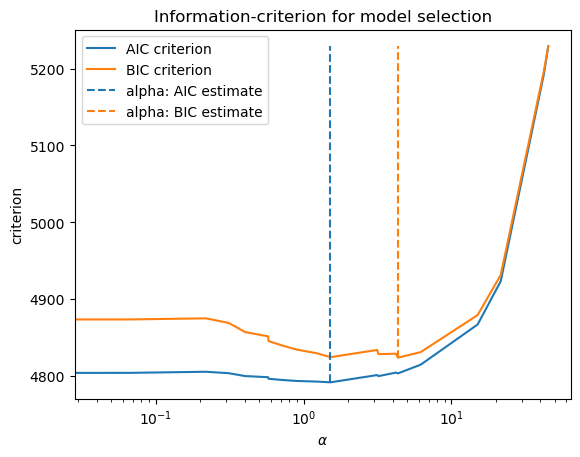

In [6]:
ax = results.plot()
ax.vlines(alpha_aic, results["AIC criterion"].min(), results["AIC criterion"].max(),
    label="alpha: AIC estimate", linestyles="--", color="tab:blue")
ax.vlines(alpha_bic, results["BIC criterion"].min(), results["BIC criterion"].max(),
    label="alpha: BIC estimate", linestyle="--", color="tab:orange")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
ax.set_title(f"Information-criterion for model selection")
plt.show()

## Model selection with cross validation

Cross-validation is a technique used to evaluate the performance of a machine learning model and to tune its hyperparameters.
It's called "cross-validation" because it involves dividing the dataset into multiple "folds" and training the model on different subsets of the data, while evaluating its performance on the remaining part of the data.

The idea is to use a different subset of the data as the validation set in each iteration, so that the model is trained and evaluated on different portions of the data.

There are several types of cross-validation, including $k$-fold cross-validation, stratified k-fold cross-validation, leave-one-out cross-validation, and others.
The specific approach depends on the nature of the data and the goals of the analysis.

The purpose of cross-validation is to get an estimate of the model's performance that is more robust and less prone to overfitting than evaluating the model on a single train/test split of the data.
By training and evaluating the model on different parts of the data, we get a better sense of how well the model will generalize to new, unseen data.

## Implementation is Scikit-learn

In Scikit-learn the Lasso estimator can be implemented with different solvers: coordinate descent and least angle regression.
They differ in regard to their execution speed and sources of numerical errors.

LassoCV and LassoLarsCV that respectively solve the problem with coordinate descent and least angle regression.

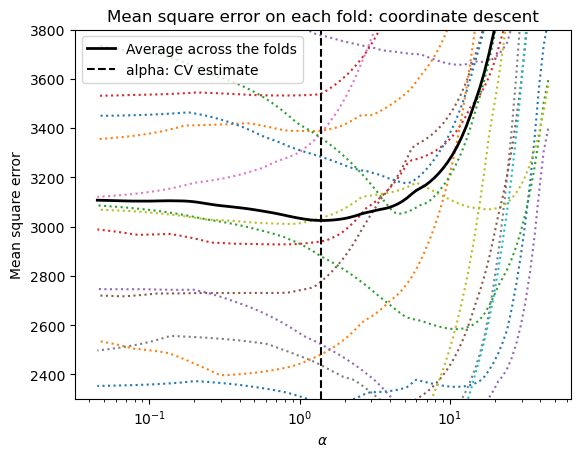

In [9]:
# Import the LassoCV class from the linear_model module of the scikit-learn library
from sklearn.linear_model import LassoCV

# Create a pipeline that standardizes the features and applies LassoCV with 10-fold cross-validation
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)

# Set the y-axis limits of the plot
ymin, ymax = 2300, 3800

# Extract the LassoCV model from the pipeline
lasso = model[-1]

# Plot the MSE path of the LassoCV model for different values of alpha on a logarithmic x-axis
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")

# Plot the average MSE across the folds for each value of alpha as a black line
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1),
    color="black", label="Average across the folds", linewidth=2)

# Add a vertical line to show the estimated alpha value selected by cross-validation
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: coordinate descent")
plt.show()

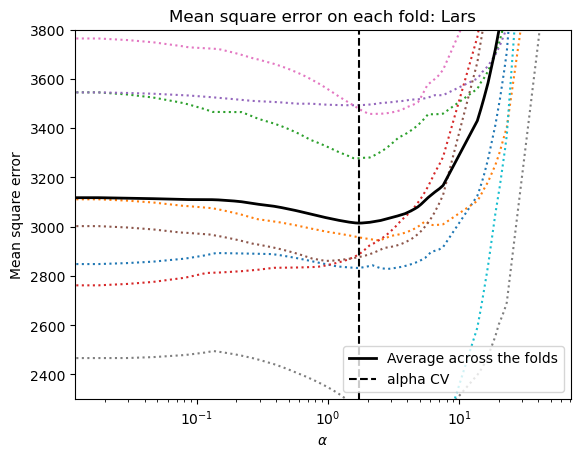

In [10]:
# Import the LassoLarsCV class from the linear_model module of the scikit-learn library
from sklearn.linear_model import LassoLarsCV

# Create a pipeline that standardizes the features and applies LassoLarsCV with 10-fold cross-validation
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=10)).fit(X, y)

# Extract the LassoLarsCV model from the pipeline
lasso = model[-1]

# Plot the MSE path of the LassoLarsCV model for different values of alpha on a logarithmic x-axis
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_, ":")

# Plot the average MSE across the folds for each value of alpha as a black line
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_.mean(axis=-1),
    color="black", label="Average across the folds", linewidth=2)

# Add a vertical line to show the estimated alpha value selected by cross-validation
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha CV")
plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: Lars")
plt.show()
